In [9]:
import matplotlib.pyplot as plt
import math
import sklearn
from tqdm import tqdm
import torch
import jax.numpy as jnp
import jax
import time
import optax
import numpy as np

from sklearn.gaussian_process.kernels import Matern

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "png")
# plt.tight_layout()
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["font.size"] = 28
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 7
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath, amssymb}']


/var/folders/3t/9g44xm4n6f74bm1skbg0kxdc0000gn/T/ipykernel_20431/1820176999.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "png")
/var/folders/3t/9g44xm4n6f74bm1skbg0kxdc0000gn/T/ipykernel_20431/1820176999.py:38: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath, amssymb}']


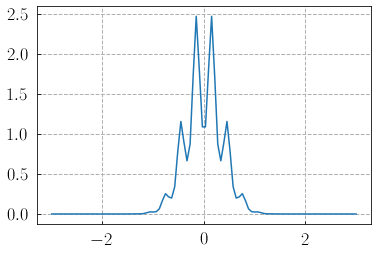

In [2]:
seed = 10
rng_key = jax.random.PRNGKey(seed)
C = 5

x = jnp.linspace(-3, 3, 100)
fx = jnp.exp(jnp.sin(C * 2 * x) ** 2 - (2 * x) ** 2)

plt.figure()
plt.plot(x, fx)
plt.show()

In [13]:


# @jax.jit
def jax_dist(x, y):
    return jnp.abs(x - y).squeeze()
distance = jax.vmap(jax_dist, in_axes=(None, 1), out_axes=1)

sign_func = jax.vmap(jnp.greater, in_axes=(None, 1), out_axes=1)

# @jax.jit
def my_Matern(x, y, l):    
    r = distance(x, y).squeeze()
    part1 = 1 + math.sqrt(3) * r / l 
    part2 = jnp.exp(-math.sqrt(3) * r / l)
    return part1 * part2


# @jax.jit
def dx_Matern(x, y, l):
    sign = sign_func(x, y).squeeze().astype(float) * 2 - 1
    r = distance(x, y).squeeze()
    part1 = jnp.exp(-math.sqrt(3) / l * r) * (math.sqrt(3) / l * sign)
    part2 = (-math.sqrt(3) / l * sign) * jnp.exp(-math.sqrt(3) / l * r) * (1 + math.sqrt(3) / l * r)
    return part1 + part2

# @jax.jit
def dy_Matern(x, y, l):
    sign = -(sign_func(x, y).squeeze().astype(float) * 2 - 1)
    r = distance(x, y).squeeze()
    part1 = jnp.exp(-math.sqrt(3) / l * r) * (math.sqrt(3) / l * sign)
    part2 = (-math.sqrt(3) / l * sign) * jnp.exp(-math.sqrt(3) / l * r) * (1 + math.sqrt(3) / l * r)
    return part1 + part2

# @jax.jit
def dxdy_Matern(x, y, l):
    r = distance(x, y).squeeze()
    const = math.sqrt(3) / l
    part1 = const * const * jnp.exp(-const * r)
    part2 = -const * const * jnp.exp(-const * r) * (1 + const * r)
    part3 = const * jnp.exp(-const * r) * const
    return -(part1 + part2 + part3)


# @jax.jit
def stein_kernel(x, y, l):
    d_log_px = -x
    d_log_py = -y
    
    K = my_Matern(x, y, l)
    dx_K = dx_Matern(x, y, l)
    dy_K = dy_Matern(x, y, l)
    dxdy_K = dxdy_Matern(x, y, l)
    part1 = d_log_px @ d_log_py.T * K
    part2 = d_log_py.T * dx_K
    part3 = d_log_px * dy_K
    part4 = dxdy_K
    return part1 + part2 + part3 + part4
    
    

100%|██████████████████████████| 50/50 [03:38<00:00,  4.37s/it]


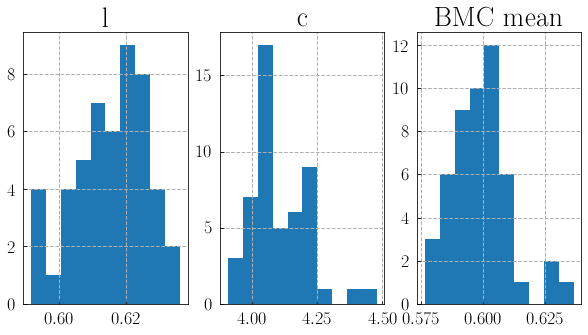

In [11]:
seed = int(time.time())
# seed = 0
rng_key = jax.random.PRNGKey(seed)
C = 5
# n_list = [200]
# n_list = jnp.concatenate((jnp.arange(3, 9), jnp.arange(1, 20) * 10))
n = 100
eps = 1e-6

l_list = jnp.array([])
c_list = jnp.array([])
MC_list = jnp.array([])
BMC_mean_list = jnp.array([])
BMC_std_list = jnp.array([])

x = jax.random.normal(rng_key, shape=(100000,))
fx = jnp.exp(jnp.sin(C * 2 * x) ** 2 - (2 * x) ** 2)
true_value = fx.mean()

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)

    
for _ in tqdm(range(50)):
    rng_key, _ = jax.random.split(rng_key)
    x = jax.random.normal(rng_key, shape=(n,))[:, None]
    fx = jnp.exp(jnp.sin(C * 2 * x) ** 2 - (2 * x) ** 2)
    MC_list = jnp.append(MC_list, fx.mean())

    c_init = c = 1.0
    log_l_init = log_l = jnp.log(0.3)
    A_init = A = 1.0 / jnp.sqrt(n)
    opt_state = optimizer.init((log_l_init, c_init, A_init))

    
    @jax.jit
    def nllk_func(log_l, c, A):
        l = jnp.exp(log_l)
        n = x.shape[0]
        K = A * stein_kernel(x, x, l) + c
        K_inv = jnp.linalg.inv(K)
        nll = -(-0.5 * fx.T @ K_inv @ fx - 0.5 * jnp.log(jnp.linalg.det(K) + eps)) / n
        return nll[0][0]

    @jax.jit
    def step(log_l, c, A, opt_state, rng_key):
        nllk_value, grads = jax.value_and_grad(nllk_func, argnums=(0, 1, 2))(log_l, c, A)
        updates, opt_state = optimizer.update(grads, opt_state, (log_l, c, A))
        log_l, c, A = optax.apply_updates((log_l, c, A), updates)
        # A = 1.0 / jnp.sqrt(n)
        # log_l = jnp.log(0.3)
        # c = 0.5
        return log_l, c, A, opt_state, nllk_value

    # Debug code
    log_l_debug_list = []
    c_debug_list = []
    A_debug_list = []
    nll_debug_list = []

    for _ in range(1000):
        rng_key, _ = jax.random.split(rng_key)
        log_l, c, A, opt_state, nllk_value = step(log_l, c, A, opt_state, rng_key)
        # Debug code
        log_l_debug_list.append(log_l)
        c_debug_list.append(c)
        A_debug_list.append(A)
        nll_debug_list.append(nllk_value)
    # Debug code
    # fig = plt.figure(figsize=(15, 6))
    # ax_1, ax_2, ax_3, ax_4 = fig.subplots(1, 4)
    # ax_1.plot(log_l_debug_list)
    # ax_2.plot(c_debug_list)
    # ax_3.plot(A_debug_list)
    # ax_4.plot(nll_debug_list)
    # plt.show()

    l = jnp.exp(log_l)
    final_K = A * stein_kernel(x, x, l) + c
    final_K_inv = jnp.linalg.inv(final_K)
    BMC_mean = c * (final_K_inv @ fx).sum()
    BMC_std = jnp.sqrt(c * c - final_K_inv.sum() * c * c)
    BMC_mean_list = jnp.append(BMC_mean_list, BMC_mean)
    BMC_std_list = jnp.append(BMC_std_list, BMC_std)

    l_list = jnp.append(l_list, l)
    c_list = jnp.append(c_list, c)


fig = plt.figure(figsize=(10, 5))
ax_1, ax_2, ax_3 = fig.subplots(1, 3)
ax_1.hist(np.array(l_list))
ax_1.set_title("l")
ax_2.hist(np.array(c_list))
ax_2.set_title("c")
ax_3.hist(np.array(BMC_mean_list))
ax_3.set_title("BMC mean")
plt.show()


In [12]:
BMC_mean_list.mean()

Array(0.5993979, dtype=float32)

In [229]:

# @jax.jit
def jax_dist(x, y):
    return jnp.abs(x - y).squeeze()
distance = jax.vmap(jax_dist, in_axes=(None, 1), out_axes=1)

sign_func = jax.vmap(jnp.greater, in_axes=(None, 1), out_axes=1)


# @jax.jit
def one_my_Matern(x, y, l):    
    r = jax_dist(x, y).squeeze()
    part1 = 1 + math.sqrt(3) * r / l 
    part2 = jnp.exp(-math.sqrt(3) * r / l)
    return part1 * part2


# @jax.jit
def one_dx_Matern(x, y, l):
    sign = jnp.greater(x, y).squeeze().astype(float) * 2 - 1
    r = jax_dist(x, y).squeeze()
    part1 = jnp.exp(-math.sqrt(3) / l * r) * (math.sqrt(3) / l * sign)
    part2 = (-math.sqrt(3) / l * sign) * jnp.exp(-math.sqrt(3) / l * r) * (1 + math.sqrt(3) / l * r)
    return part1 + part2

# @jax.jit
def one_dy_Matern(x, y, l):
    sign = -(jnp.greater(x, y).squeeze().astype(float) * 2 - 1)
    r = jax_dist(x, y).squeeze()
    part1 = jnp.exp(-math.sqrt(3) / l * r) * (math.sqrt(3) / l * sign)
    part2 = (-math.sqrt(3) / l * sign) * jnp.exp(-math.sqrt(3) / l * r) * (1 + math.sqrt(3) / l * r)
    return part1 + part2

# @jax.jit
def one_dxdy_Matern(x, y, l):
    r = jax_dist(x, y).squeeze()
    const = math.sqrt(3) / l
    part1 = const * const * jnp.exp(-const * r)
    part2 = -const * const * jnp.exp(-const * r) * (1 + const * r)
    part3 = const * jnp.exp(-const * r) * const
    return part1 + part2 + part3



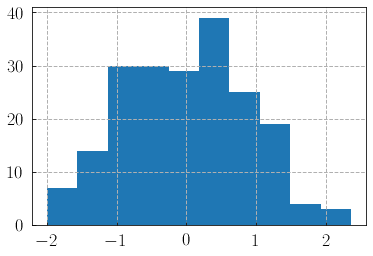

In [292]:

histogram = []

for _ in range(200):
    rng_key, _ = jax.random.split(rng_key)
    x = jax.random.normal(rng_key, shape = (1, ))[:, None]

    rng_key, _ = jax.random.split(rng_key)
    x_prime = jax.random.normal(rng_key, shape = (1, ))[:, None]

    l = 3.0

    a = (-x) * one_my_Matern(x, x_prime, l) + one_dx_Matern(x, x_prime, l)
    histogram.append(a[0, 0])
    
plt.figure()
plt.hist(np.array(histogram))
plt.show()

In [338]:

rng_key, _ = jax.random.split(rng_key)
x = jax.random.normal(rng_key, shape = (500, ))[:, None]

rng_key, _ = jax.random.split(rng_key)
x_prime = jax.random.normal(rng_key, shape = (10, ))[:, None]

l = 3.0

a = (-x) * my_Matern(x, x_prime, l) + dx_Matern(x, x_prime, l)

print(a.mean(0))

[-0.01573705 -0.01311152 -0.01600022 -0.01593722 -0.00833299 -0.01216601
 -0.01242753 -0.01592519 -0.01413894 -0.01519885]


In [324]:
a


Array([[-0.89892334, -1.1321104 , -1.0569068 , -1.1968758 , -0.91308355],
       [-0.40051728, -0.04894108, -0.38414705, -0.20465195, -0.40147418],
       [-0.6043762 , -0.3737574 , -0.65099454, -0.5758727 , -0.61021996],
       [-0.2976899 ,  0.08099225, -0.25288084, -0.04457453, -0.29638743],
       [-0.48435056, -0.17002887, -0.49276942, -0.35038942, -0.4872484 ],
       [-1.0430348 , -1.7218596 , -1.2741429 , -1.5722673 , -1.0624139 ],
       [ 0.09973219,  0.4510066 ,  0.2352938 ,  0.43198344,  0.10858467],
       [-0.64344573, -0.44964328, -0.7032496 , -0.65215355, -0.65029484],
       [-0.14950433,  0.2397761 , -0.06734238,  0.15614454, -0.1451699 ],
       [-0.49189794, -0.1817047 , -0.50262225, -0.36419725, -0.49497503],
       [ 0.6756475 ,  0.7733009 ,  0.8588927 ,  0.87486994,  0.69196546],
       [ 1.264801  ,  0.9684012 ,  1.3155229 ,  1.1618527 ,  1.278575  ],
       [ 1.9896922 ,  1.1193811 ,  1.7793498 ,  1.4144394 ,  1.9761517 ],
       [ 1.3365896 ,  0.9871602 ,  1.3

In [308]:

rng_key, _ = jax.random.split(rng_key)
x = jax.random.normal(rng_key, shape = (2, ))[:, None]

rng_key, _ = jax.random.split(rng_key)
x_prime = jax.random.normal(rng_key, shape = (2, ))[:, None]

l = 3.0

a = (-x) * my_Matern(x, x_prime, l) + dx_Matern(x, x_prime, l)
print(a)

x_one = x[0, :][None, :]
x_prime_one = x_prime[0, :][None, :]
b = (-x_one) * one_my_Matern(x_one, x_prime_one, l) + one_dx_Matern(x_one, x_prime_one, l)
print(b)

x_one = x[1, :][None, :]
x_prime_one = x_prime[0, :][None, :]
b = (-x_one) * one_my_Matern(x_one, x_prime_one, l) + one_dx_Matern(x_one, x_prime_one, l)
print(b)

x_one = x[0, :][None, :]
x_prime_one = x_prime[1, :][None, :]
b = (-x_one) * one_my_Matern(x_one, x_prime_one, l) + one_dx_Matern(x_one, x_prime_one, l)
print(b)

x_one = x[1, :][None, :]
x_prime_one = x_prime[1, :][None, :]
b = (-x_one) * one_my_Matern(x_one, x_prime_one, l) + one_dx_Matern(x_one, x_prime_one, l)
print(b)

[[0.8648602  1.260222  ]
 [0.47789904 0.39241144]]
[[0.8648602]]
[[0.47789904]]
[[1.260222]]
[[0.39241144]]


In [306]:
one_my_Matern(x, x_prime_one, l).shape

(2,)

In [307]:
x.shape

(2, 1)